In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
import numpy as np
import makassar_ml as ml
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
import json
sns.set() # Use seaborn themes.

In [2]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [3]:
def fuse_dated_images_timeseries(
    ds_images_dates: tf.data.Dataset,
    df_timeseries: pd.DataFrame,
    timedelta_dict: dict, # i.e., {'days':1, 'hours':24, 'minutes':5}
    datetime_column: str = 'datetime',
    datetime_format: str = '%Y-%m-%d %H:%M:%S',
    features: list[str] = None,
    ):

    # Set the index to datetime so lookup is quicker.
    df_timeseries_datetimeindex = df_timeseries.set_index([datetime_column])

    def gen():
        for (image, date), label in ds_images_dates:
            end_date = dt.datetime.strptime(date.numpy().decode('utf8'), datetime_format)
            start_date = end_date - dt.timedelta(**timedelta_dict)
            df_timeseries_range = df_timeseries_datetimeindex.loc[start_date:end_date]
            df_timeseries_range.reset_index(inplace=True)
            if features is not None:
                df_timeseries_range = df_timeseries_range[features]
            tensor_timeseries_range = tf.convert_to_tensor(df_timeseries_range)
            yield ((image, tensor_timeseries_range), label)

    ds_fused = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (
                tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8), # image
                tf.TensorSpec(shape=(None, None), dtype=tf.float32), # timeseries
            ),
            tf.TensorSpec(shape=(), dtype=tf.int64), # label
        ),
    )
    # Set length of dataset since it will be the same as the image dataset.
    ds_fused = ds_fused.apply(tf.data.experimental.assert_cardinality(tf.data.experimental.cardinality(ds_images_dates)))
    return ds_fused

In [4]:
# Load image dataset.
ds_images, info = tfds.load(
    name='plant_village',
    split='train',
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
)
label_names = info.features['label'].names

# Load weather dataset.
df_weather = ml.datasets.beijingpm25.load_beijingpm25_df(
    path=Path("~/research/makassar/datasets/beijing_pm25").expanduser(),
)

In [5]:
# Generate random distribution of dates to associated with the images.
hours = 72
reserve_offset_index = hours + 1
timeseries_datetime_column = 'datetime'
n_images = int(ds_images.cardinality())
random_dates = df_weather.iloc[reserve_offset_index:].sample(n=n_images, replace=True)[timeseries_datetime_column]

Text(0, 0.5, 'count')

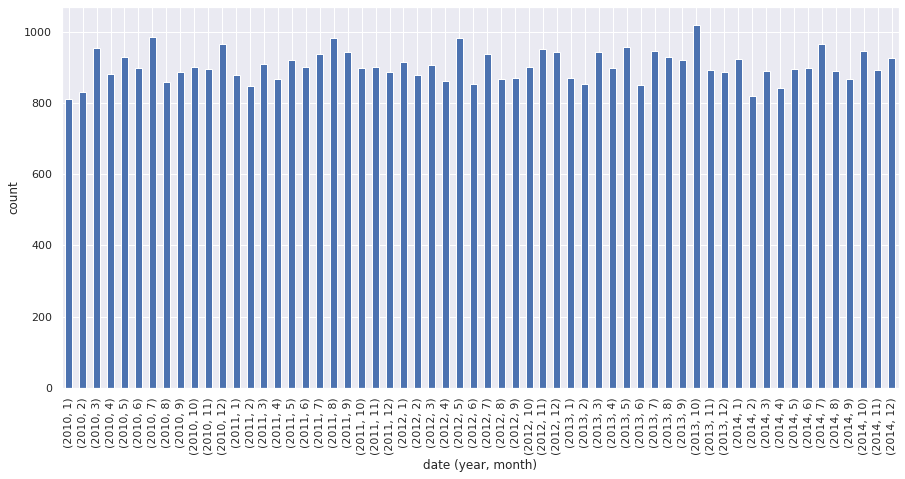

In [6]:
# Plot distribution of dates.
plt.figure(figsize=(15,7))
random_dates.groupby([random_dates.dt.year, random_dates.dt.month]).count().plot(kind="bar")
plt.xlabel('date (year, month)')
plt.ylabel('count')

In [7]:
# Fuse images with dates.
ds_images_dates = tf.data.Dataset.zip(
    (ds_images, tf.data.Dataset.from_tensor_slices(random_dates.astype(str)))
).map(
    lambda image_label, datestring: ((image_label[0], datestring), image_label[1]) # Reorder to ((image, date), label).
)

In [8]:
for (image, date), label in ds_images_dates.batch(128).take(5):
    print(image.shape)
    print(label.shape)
    print(date.shape)
    break

(128, 256, 256, 3)
(128,)
(128,)


In [9]:
ds_fused = fuse_dated_images_timeseries(
    ds_images_dates=ds_images_dates, 
    df_timeseries=df_weather,
    timedelta_dict=dict(hours=hours),
    features=['DEWP', 'TEMP','PRES','Iws','Is','Ir'],
)
for (image, data), label in ds_fused.batch(128).take(1):
    print(image.shape, data.shape, label.shape)
    break

(128, 256, 256, 3) (128, 73, 6) (128,)


In [10]:
def image_augmentation(image: tf.Tensor, size: tuple[int,int] = None):
    if size is not None:
        dtype = image.dtype # Preserve original data type for casting after resize operation.
        image = tf.image.resize(image, size=size)
        image = tf.cast(image, dtype)
    # image = keras.layers.experimental.preprocessing.Resizing(200,200)(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.cast(image, dtype=tf.float32) / tf.constant(256, dtype=tf.float32) # Rescale.
    # image = tfa.image.rotate(image, tf.random.normal(shape=[])*np.pi/180., interpolation='bilinear')
    return image

In [11]:
image_shape = (72, 72, 3)
ds_fused = ds_fused.map(lambda image_data, label: ((image_augmentation(image_data[0], size=(image_shape[0], image_shape[1])), image_data[1]), label))

In [12]:
# Visual Forecast Transformer (ViFoT)
# inputs are images + weather
# output is plant health
def ViFoT(
    image_shape: tuple,
    patch_size: int,
    num_patches: int,
    seq_in_seq_len: int,
    seq_in_feat: int,
    seq_out_feat: int,
    image_embed_dim: int,
    seq_embed_dim: int,
    n_class: int,
    image_n_encoders: int = 3,
    seq_n_encoders: int = 3,
    image_n_heads: int = 8,
    seq_n_heads: int = 8,
    image_ff_dim: int = 2048,
    seq_ff_dim: int = 2048,
    dropout: float = 0.0,
    image_fc_units: list[int] = [],
    ):

    ###
    # Image Branch.
    ###

    # Input tensor.
    inp_image = keras.Input(shape=image_shape)
    # Vision Transformer for image feature extraction.
    x_image = ml.models.vit.ViT(
        image_shape=image_shape,
        patch_size=patch_size,
        num_patches=num_patches,
        embed_dim=image_embed_dim,
        n_class=n_class,
        n_encoders=image_n_encoders,
        n_heads=image_n_heads,
        ff_dim=image_ff_dim,
        dropout=dropout,
        fc_units=image_fc_units,
        include_top=False,
    )(inp_image)

    ###
    # Sequence Branch.
    ###
    inp_seq = keras.Input(shape=(seq_in_seq_len, seq_in_feat))
    x_seq = ml.models.fot.FoT(
        in_seq_len=seq_in_seq_len,
        in_feat=seq_in_feat,
        embed_dim=seq_embed_dim,
        out_feat=seq_out_feat,
        n_heads=seq_n_heads,
        key_dim=None,
        value_dim=None,
        ff_dim=seq_ff_dim,
        dropout=dropout,
        n_encoders=seq_n_encoders,
        include_top=False,
    )(inp_seq)

    ###
    # Combine results from all branches.
    ###
    # Flatten to ensure tensors can be concatenated.
    x_image = keras.layers.Flatten(data_format='channels_last')(x_image)
    x_seq = keras.layers.Flatten(data_format='channels_last')(x_seq)
    # Concatenate them.
    x = keras.layers.Concatenate(axis=-1)([x_image, x_seq])

    # Add intermediate dense layers with ReLU activation.
    if image_fc_units:
        for units in image_fc_units:
            x = keras.layers.Dense(units=units, activation='relu')(x)

    # Classifier on the end.
    x = keras.layers.Dense(units=n_class, activation='softmax')(x)


    return keras.Model(inputs=[inp_image, inp_seq], outputs=[x])


# image_shape = (256, 256, 3)
patch_size = 6
model = ViFoT(
    image_shape=image_shape,
    patch_size=patch_size,
    num_patches=(image_shape[0]//patch_size)**2,
    seq_in_seq_len=hours+1,
    seq_in_feat=6,
    seq_out_feat=1,
    image_embed_dim=32,
    seq_embed_dim=32,
    n_class=len(label_names),
    image_n_encoders=3,
    seq_n_encoders=3,
    image_n_heads=8,
    seq_n_heads=8,
    image_ff_dim=256,
    seq_ff_dim=256,
    dropout=0.1,
)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

ds_fused_size = tf.data.experimental.cardinality(ds_fused).numpy()
ds_train, ds_val, ds_test = ml.datasets.utility.partition_dataset_ds(
    ds=ds_fused,
    split=[0.7,0.2,0.1],
)

# ds_train = ds_train.batch(128).prefetch(tf.data.AUTOTUNE).cache()
# ds_val = ds_val.batch(128).prefetch(tf.data.AUTOTUNE).cache()
# ds_test = ds_test.batch(128).prefetch(tf.data.AUTOTUNE).cache()

# history = model.fit(ds_fused.batch(128).prefetch(tf.data.AUTOTUNE).take(256).cache(), epochs=10, verbose=1)

checkpoint_path = Path('vifot.ckpt')
history_path = Path('vifot_history.json')
force = False

if force or not checkpoint_path.exists():
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=str(checkpoint_path),
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            # verbose=1,
        ),
    ]

    history = model.fit(
        ds_train.batch(128).prefetch(tf.data.AUTOTUNE).cache(),
        validation_data=ds_val.batch(128).prefetch(tf.data.AUTOTUNE).cache(), 
        epochs=10,
        verbose=1,
        callbacks=callbacks,
    )

    history = history.history
    with open(history_path, 'w') as f:
        json.dump(history, f)

else:
    model = keras.models.load_model(str(checkpoint_path), custom_objects=keras.utils.get_custom_objects())
    with open(history_path, 'r') as f:
        history = json.load(f)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 73, 6)]      0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 144, 32)      71168       input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 73, 198)      782367      input_3[0][0]                    
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: vifot.ckpt/assets


INFO:tensorflow:Assets written to: vifot.ckpt/assets


Epoch 2/10
297/297 [==============================] - 29s 97ms/step - loss: 1.4317 - accuracy: 0.5893 - val_loss: 1.1433 - val_accuracy: 0.6624


INFO:tensorflow:Assets written to: vifot.ckpt/assets


INFO:tensorflow:Assets written to: vifot.ckpt/assets


Epoch 3/10
297/297 [==============================] - 29s 97ms/step - loss: 1.0964 - accuracy: 0.6843 - val_loss: 0.9576 - val_accuracy: 0.7131


INFO:tensorflow:Assets written to: vifot.ckpt/assets


INFO:tensorflow:Assets written to: vifot.ckpt/assets


Epoch 4/10
297/297 [==============================] - 29s 97ms/step - loss: 0.8907 - accuracy: 0.7405 - val_loss: 0.8482 - val_accuracy: 0.7441


INFO:tensorflow:Assets written to: vifot.ckpt/assets


INFO:tensorflow:Assets written to: vifot.ckpt/assets


Epoch 5/10
297/297 [==============================] - 29s 97ms/step - loss: 0.7489 - accuracy: 0.7806 - val_loss: 0.7693 - val_accuracy: 0.7652


INFO:tensorflow:Assets written to: vifot.ckpt/assets


INFO:tensorflow:Assets written to: vifot.ckpt/assets


Epoch 6/10
297/297 [==============================] - 29s 97ms/step - loss: 0.6463 - accuracy: 0.8116 - val_loss: 0.7099 - val_accuracy: 0.7807


INFO:tensorflow:Assets written to: vifot.ckpt/assets


INFO:tensorflow:Assets written to: vifot.ckpt/assets


Epoch 7/10
297/297 [==============================] - 29s 97ms/step - loss: 0.5622 - accuracy: 0.8357 - val_loss: 0.6585 - val_accuracy: 0.7968


INFO:tensorflow:Assets written to: vifot.ckpt/assets


INFO:tensorflow:Assets written to: vifot.ckpt/assets


Epoch 8/10
297/297 [==============================] - 29s 97ms/step - loss: 0.4905 - accuracy: 0.8578 - val_loss: 0.6232 - val_accuracy: 0.8063


INFO:tensorflow:Assets written to: vifot.ckpt/assets


INFO:tensorflow:Assets written to: vifot.ckpt/assets


Epoch 9/10
297/297 [==============================] - 29s 97ms/step - loss: 0.4344 - accuracy: 0.8752 - val_loss: 0.5734 - val_accuracy: 0.8221


INFO:tensorflow:Assets written to: vifot.ckpt/assets


INFO:tensorflow:Assets written to: vifot.ckpt/assets


Epoch 10/10
297/297 [==============================] - 29s 97ms/step - loss: 0.3845 - accuracy: 0.8917 - val_loss: 0.5445 - val_accuracy: 0.8316


INFO:tensorflow:Assets written to: vifot.ckpt/assets


INFO:tensorflow:Assets written to: vifot.ckpt/assets


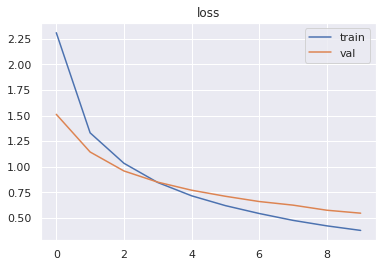

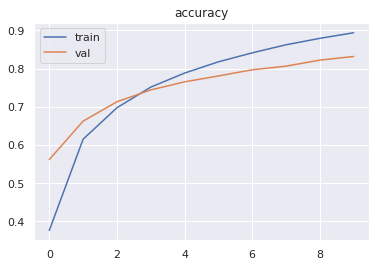

In [13]:
for key in ['loss', 'accuracy']:
    plt.figure()
    if key in history:
        plt.plot(history[key], label='train')
    key_val = f"val_{key}"
    if key_val in history:
        plt.plot(history[key_val], label='val')
    plt.legend()
    plt.title(key)

In [14]:
# for item in ds_test.unbatch():
#     print(item)
#     break

# in_data = ds_test.take(1)
# pred = model.predict(in_data)
# print(pred.shape)


# n = 5
# for k, (((image, data), label), label_pred) in enumerate(zip(in_data.unbatch(), pred)):
#     print(image.shape)
#     print(data.shape)
#     print(label_pred.shape)
#     label_pred_index = tf.math.argmax(label_pred)

#     fig = plt.figure(figsize=(15,7), constrained_layout=True)
#     subfigs = fig.subfigures(1, 2, wspace=0.1)

#     # Left.
#     left_axes = subfigs[0].subplots()
#     left_axes.imshow(image)
#     left_axes.axis("off")
#     left_axes.set_title(f"({label}, {label_names[label.numpy()]}) --> ({label_pred_index}, {label_names[label_pred_index]})")

#     # Right.
#     features = ['DEWP','TEMP','PRES','Iws','Is','Ir']
#     nrows = data.shape[-1]
#     right_axes = subfigs[1].subplots(nrows=nrows, ncols=1, sharex=True, squeeze=False)
#     for i in range(nrows):
#         right_axes[i,0].plot(data[:,i])
#         right_axes[i,0].set_ylabel(features[i])
 
#     if k >= n:
#         break